# W261 Final Project - Experiment, Fine-Tune, Select the Optimal Pipeline (Coding Notebook - Ensemble Tree Models)
## Section 02, Team 1: Aimee, Dylan, Jo, Vicky

In [0]:
# Read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

# Read the checkpointed train and test datasets
df_train_downsampled = spark.read.parquet(f"{folder_path}/df_train_downsampled.parquet")
df_test = spark.read.parquet(f"{folder_path}/df_test.parquet")
df_train = spark.read.parquet(f"{folder_path}/df_train.parquet")

# Setup & Directory

In [0]:
# Basic Functions
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
 
# For feature engineering
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder, ChiSqSelector, Bucketizer, Imputer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
 
# For EDA/plotting & basic funcs
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1, style='whitegrid')
import random
from math import floor
 
# For Modeling
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import classification_report
import itertools 
from xgboost.spark import SparkXGBClassifier


# Ensemble Trees

In [0]:
# Print to confirm the data is loaded correctly
df_train_downsampled.limit(10).toPandas().head()

,DEST,ORIGIN,OP_CARRIER_AIRLINE_ID,ORIGIN_STATE_ABR,DEST_STATE_ABR,DEP_DEL15,DIVERTED,DISTANCE_GROUP,MONTH,origin_type,dest_type,dest_airport_lat,dest_airport_lon,sched_depart_date_time_UTC,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,prev_flight_delay_ind,is_holiday,is_weekend,origin_pagerank,dest_pagerank
0,DEN,DSM,20366,IA,CO,1,0.0,3,2,large_airport,large_airport,39.8,-104.7,2015-02-13 01:32:00,15.0,0.0,0.0400,6.0,59.0,30.45,29.36,10.0,25.23832,7.0,1,0,0,1.260691,10.264866
1,MEM,IAH,20366,TX,TN,1,0.0,2,2,large_airport,large_airport,35.1,-90.0,2015-02-17 20:33:00,52.0,0.0,0.0023,-1.0,43.0,30.17,30.06,10.0,25.23832,10.0,1,1,0,5.946030,1.457592
2,JAN,IAH,20366,TX,MS,1,0.0,2,5,large_airport,large_airport,32.3,-90.1,2015-05-18 22:08:00,75.0,0.0,0.0023,-1.0,84.0,30.06,29.95,10.0,25.23832,11.0,1,0,0,5.946030,0.587401
3,RAP,DEN,20366,CO,SD,1,0.0,2,6,large_airport,medium_airport,44.0,-103.1,2015-06-20 04:06:00,67.0,0.0,0.0023,-1.0,55.0,29.66,24.51,10.0,25.23832,11.0,1,0,1,10.264866,0.862933
4,ORD,CHS,20366,SC,IL,1,0.0,4,7,large_airport,large_airport,42.0,-87.9,2016-07-28 21:00:00,91.0,0.0,0.0023,-1.0,61.0,29.92,29.88,10.0,25.23832,14.0,1,0,0,1.350306,11.044592


In [0]:
# Print to confirm the data is loaded correctly
df_test.limit(10).toPandas().head()

,DEST,ORIGIN,OP_CARRIER_AIRLINE_ID,ORIGIN_STATE_ABR,DEST_STATE_ABR,DEP_DEL15,DIVERTED,DISTANCE_GROUP,MONTH,origin_type,dest_type,dest_airport_lat,dest_airport_lon,sched_depart_date_time_UTC,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,prev_flight_delay_ind,is_holiday,is_weekend,origin_pagerank,dest_pagerank
0,CVG,FLL,20368,FL,KY,0,0.0,4,3,large_airport,large_airport,39.0,-84.7,2019-03-06 16:33:00,69.0,0.0,0.0100,8.0,41.0,30.25,30.24,10.0,23.023088,11.0,0,0,0,3.439324,2.431608
1,SFB,GSP,20368,SC,FL,0,0.0,2,3,large_airport,large_airport,28.8,-81.2,2019-03-21 22:32:00,49.0,0.0,-0.0700,1.0,64.0,29.85,28.82,10.0,22.923985,0.0,0,0,0,1.213951,3.712784
2,LAX,CVG,20368,KY,CA,0,0.0,8,4,large_airport,large_airport,33.9,-118.4,2019-04-07 10:30:00,55.0,0.0,-0.0100,3.0,74.0,30.03,29.09,10.0,24.228681,8.0,1,0,1,2.431608,5.738706
3,PGD,CVG,20368,KY,FL,0,0.0,4,4,large_airport,small_airport,26.9,-82.0,2019-04-18 21:29:00,74.0,0.0,-0.0011,-1.0,48.0,29.59,28.69,10.0,24.228681,10.0,0,0,0,2.431608,2.414726
4,ELM,PIE,20368,FL,NY,0,0.0,5,8,medium_airport,medium_airport,42.2,-76.9,2019-08-21 19:36:00,92.0,0.0,0.0400,6.0,49.0,30.03,30.02,10.0,21.616916,3.0,0,0,0,2.826869,0.401931


In [0]:
df_train_downsampled.dtypes

[('DEST', 'string'),
 ('ORIGIN', 'string'),
 ('OP_CARRIER_AIRLINE_ID', 'string'),
 ('ORIGIN_STATE_ABR', 'string'),
 ('DEST_STATE_ABR', 'string'),
 ('DEP_DEL15', 'int'),
 ('DIVERTED', 'string'),
 ('DISTANCE_GROUP', 'string'),
 ('MONTH', 'string'),
 ('origin_type', 'string'),
 ('dest_type', 'string'),
 ('dest_airport_lat', 'double'),
 ('dest_airport_lon', 'double'),
 ('sched_depart_date_time_UTC', 'timestamp'),
 ('HourlyDryBulbTemperature', 'double'),
 ('HourlyPrecipitation', 'double'),
 ('HourlyPressureChange', 'double'),
 ('HourlyPressureTendency', 'double'),
 ('HourlyRelativeHumidity', 'double'),
 ('HourlySeaLevelPressure', 'double'),
 ('HourlyStationPressure', 'double'),
 ('HourlyVisibility', 'double'),
 ('HourlyWindGustSpeed', 'double'),
 ('HourlyWindSpeed', 'double'),
 ('prev_flight_delay_ind', 'int'),
 ('is_holiday', 'int'),
 ('is_weekend', 'int'),
 ('origin_pagerank', 'double'),
 ('dest_pagerank', 'double')]

In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, FeatureHasher
from pyspark.ml import Pipeline

def tree_pipeline(model):
    """
    Optimized pipeline for tree-type algorithms (GBT/XGBoost) with updated features.
    """

    # Continuous features (adjusted for your dataset)
    cont_feat = [
        'dest_airport_lat', 'dest_airport_lon', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
        'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
        'HourlyStationPressure', 'HourlyVisibility', 'HourlyWindGustSpeed', 
        'HourlyWindSpeed', 'origin_pagerank', 'dest_pagerank'
    ]

    # Assemble continuous features
    assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")

    # Categorical features (updated for your dataset)
    columns_categorical = [
        'OP_CARRIER_AIRLINE_ID', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 
        'DIVERTED', 'DISTANCE_GROUP', 'MONTH', 'origin_type', 'dest_type', 'prev_flight_delay_ind', 'is_holiday', 'is_weekend'
    ]

    # StringIndexer for categorical columns
    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in columns_categorical]

    # Use FeatureHasher for hashing categorical columns
    hasher = FeatureHasher(inputCols=[f"{c}_indexed" for c in columns_categorical], 
                           outputCol="hashed_features", numFeatures=500)

    # Assemble all features into a single vector column
    assembler = VectorAssembler(inputCols=["cont_features", "hashed_features"], outputCol="features")

    # Define the pipeline stages
    stages = [assembler_cont] + indexers + [hasher, assembler, model]

    # Build the pipeline
    pipeline = Pipeline(stages=stages)

    return pipeline


In [0]:
from xgboost.spark import SparkXGBClassifier

def get_model(model_type, pipeline_func, p):
  """
  Input: name of model, the pipeline function for that model and a set of parameters
  Output: a pipeline object for the input model type
  """
  if model_type == 'gbt':
    gbt = GBTClassifier(labelCol="DEP_DEL15",
                        featuresCol="features",
                        maxDepth=p["maxDepth"],
                        maxBins=p["maxBins"],
                        maxIter=p["maxIter"],
                        stepSize=p["stepSize"])
    pipeline = pipeline_func(gbt)
    
  elif model_type == 'xgboost':
    xgboost = SparkXGBClassifier(
        label_col="DEP_DEL15",  # Ensure this is the target column for classification (binary or multi-class labels)
        features_col="features",  # The feature column
        missing=0.0,
        raw_prediction_col='probability',  # This is for storing the prediction probabilities in classification tasks
        max_depth=p["max_depth"],
        n_estimators=p["n_estimators"],
        reg_lambda=p["reg_lambda"],
        reg_alpha=p["reg_alpha"],
        base_score=p["base_score"],
        learning_rate=p["learning_rate"],
        gamma=p["gamma"],
        min_child_weight=p["min_child_weight"],
        tree_method=p["tree_method"],  
        num_workers=p["num_workers"]   
    )
    pipeline = pipeline_func(xgboost)
    
  return pipeline

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import col


def evaluate_classification_model(prediction, label_col="DEP_DEL15", prediction_col="prediction"):

    predictions_and_labels = prediction.select(prediction_col, label_col)

    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)

    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()

    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    # roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    # pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    return {
        "precision": precision,
        "recall": recall,
        "f2_score": f2_score,
        "Confusion Matrix Values": [[TN, FP], [FN, TP]]
    }


def plot_confusion_matrix(conf_matrix_values, title_suffix=""):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    conf_matrix = np.array(conf_matrix_values)

    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  index=["Actual Negative (0)", "Actual Positive (1)"], 
                                  columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    title = "Confusion Matrix"
    if title_suffix:
        title += f" ({title_suffix})"
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from itertools import product
import numpy as np
import pandas as pd

class BlockedTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, df):
        return self.n_splits

    def split(self, df):
        df_sorted = df.orderBy('sched_depart_date_time_UTC').cache()
        timestamps = df_sorted.select("sched_depart_date_time_UTC").rdd.map(lambda r: r[0]).collect()
        n_samples = len(timestamps)
        split_size = n_samples // self.n_splits

        for i in range(self.n_splits):
            start_idx = i * split_size
            stop_idx = min(start_idx + split_size, n_samples)
            mid_idx = start_idx + int(0.8 * (stop_idx - start_idx))

            train_start = timestamps[start_idx]
            train_end = timestamps[mid_idx - 1]
            val_start = timestamps[mid_idx]
            val_end = timestamps[stop_idx - 1]

            train_data = df.filter((F.col("sched_depart_date_time_UTC") >= train_start) &
                                (F.col("sched_depart_date_time_UTC") <= train_end))

            val_data = df.filter((F.col("sched_depart_date_time_UTC") > train_end) &
                                (F.col("sched_depart_date_time_UTC") <= val_end))

            yield train_data, val_data


def parameter_sets(param_grid):
    parameter_names = list(param_grid.keys())
    parameters = list(product(*param_grid.values()))
    return parameter_names, parameters


def cross_validate_with_blocked_time_series_split(model_name, pipeline_func, param_grid, df, n_splits):
    splitter = BlockedTimeSeriesSplit(n_splits)
    param_names, param_combinations = parameter_sets(param_grid)

    best_score = 0
    best_params = None
    best_metrics = None
    all_results = []

    for params in param_combinations:
        params_dict = dict(zip(param_names, params))
        print(f"Testing params: {params_dict}")

        metrics = {
            'train_f2_score': [],
            'val_f2_score': [],
            'precision': [],
            'recall': []
        }

        for train_data, val_data in splitter.split(df):
            pipeline = get_model(model_name, pipeline_func, params_dict)
            model = pipeline.fit(train_data)

            # Evaluate on train
            train_preds = model.transform(train_data)
            train_f2 = evaluate_classification_model(train_preds)['f2_score']
            metrics['train_f2_score'].append(train_f2)

            # Evaluate on validation
            val_preds = model.transform(val_data)
            val_scores = evaluate_classification_model(val_preds)
            metrics['val_f2_score'].append(val_scores['f2_score'])
            metrics['precision'].append(val_scores['precision'])
            metrics['recall'].append(val_scores['recall'])

        # Compute mean and std for metrics
        avg_metrics = {k: np.mean(v) for k, v in metrics.items()}
        std_metrics = {
            'val_f2_score_std': np.std(metrics['val_f2_score'])  # Add std for validation F2 score
        }
        avg_metrics.update(std_metrics)

        result_row = params_dict.copy()
        result_row.update(avg_metrics)
        all_results.append(result_row)

        # Use only validation F2 to pick best model
        if avg_metrics['val_f2_score'] > best_score:
            best_score = avg_metrics['val_f2_score']
            best_params = params_dict
            best_metrics = avg_metrics

    print("\n===============================")
    print(f"Best CV F2 Score: {best_score}")
    print(f"Best Params: {best_params}")
    print(f"Best Metrics: {best_metrics}")
    print("===============================")

    results_df = pd.DataFrame(all_results)
    return results_df, best_params, best_metrics

In [0]:
import matplotlib.pyplot as plt
## Define Plot Feature Function
def plot_feature_importance(fi: dict, model_name: str, top: int = 10):
    fi_df = pd.DataFrame({"Feature Name": fi.keys(), "Importance": fi.values()})
    # Remove _ix suffix from PySpark feature creation:
    fi_df["Feature Name"] = [s.replace("_ix", "") for s in fi_df["Feature Name"].values]
    fi_df = fi_df.set_index("Feature Name").sort_values("Importance", ascending=False).head(top)

    fig, ax = plt.subplots(figsize=(6, 5), dpi=200)
    fi_df.iloc[::-1].plot(kind="barh", title = f"{model_name} Feature Importance", ax=ax)

## Hyperparameter Tuning

In [0]:
# Set Spark configurations to handle shuffle block fetch failures
spark.conf.set("spark.shuffle.io.maxRetries", "10")
spark.conf.set("spark.shuffle.io.retryWait", "5s")
spark.conf.set("spark.sql.shuffle.partitions", "200")

# Cross-validation: XGBoost using 60 month data
p_xgb = {
    "max_depth": [4, 5],
    "n_estimators": [200],
    "reg_lambda": [1.0, 5.0],
    "reg_alpha": [0.1, 1],
    "base_score": [0.5],
    "learning_rate": [0.05, 0.1],
    "gamma": [0, 1],
    "min_child_weight": [3],
    "tree_method": ["hist"],   
    "num_workers": [5]   
}

# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna()
all_results, best_params, best_metrics = cross_validate_with_blocked_time_series_split(
    model_name = 'xgboost', 
    pipeline_func=tree_pipeline, 
    param_grid=p_xgb,
    df=df_train_downsampled, 
    n_splits=3)

display(all_results)

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster 

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster pa

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.05, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 0, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': 1, 'reg_lambda': 5.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params


Best CV F2 Score: 0.6060753725504494
Best Params: {'max_depth': 5, 'n_estimators': 200, 'reg_lambda': 5.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 3, 'tree_method': 'hist', 'num_workers': 5}
Best Metrics: {'train_f2_score': 0.6632696157551657, 'val_f2_score': 0.6060753725504494, 'precision': 0.6562649861644317, 'recall': 0.5955165362464158, 'val_f2_score_std': 0.029364116102198922}


max_depth,n_estimators,reg_lambda,reg_alpha,base_score,learning_rate,gamma,min_child_weight,tree_method,num_workers,train_f2_score,val_f2_score,precision,recall,val_f2_score_std
4,200,1.0,0.1,0.5,0.05,0,3,hist,5,0.6426871492961452,0.5956982919046112,0.6540997433722359,0.5832869181972925,0.02404630155614321
4,200,1.0,0.1,0.5,0.05,1,3,hist,5,0.6426871492961452,0.5956982919046112,0.6540997433722359,0.5832869181972925,0.02404630155614321
4,200,1.0,0.1,0.5,0.1,0,3,hist,5,0.6533803265956889,0.6001448851094223,0.6553598754638535,0.5884497539955529,0.025824682557709748
4,200,1.0,0.1,0.5,0.1,1,3,hist,5,0.6535457925277807,0.6003301536078228,0.6554190289437848,0.5886646837767291,0.02592541001176165
4,200,1.0,1.0,0.5,0.05,0,3,hist,5,0.6432623370761629,0.595007694939635,0.6542907588370572,0.582434513532087,0.024358062119767637
4,200,1.0,1.0,0.5,0.05,1,3,hist,5,0.6432315207598197,0.5949658357953781,0.654325905546588,0.582375091769056,0.024338761208148547
4,200,1.0,1.0,0.5,0.1,0,3,hist,5,0.6529051203890106,0.5999651408838069,0.6555812589875832,0.5881985260724562,0.025661022310566828
4,200,1.0,1.0,0.5,0.1,1,3,hist,5,0.6528666133306484,0.5999385409960228,0.655684498809728,0.588132602885388,0.025494429658115027
4,200,5.0,0.1,0.5,0.05,0,3,hist,5,0.6432928568627507,0.5951605343453452,0.6545260135453054,0.5825926858948965,0.024797381718998694
4,200,5.0,0.1,0.5,0.05,1,3,hist,5,0.6432927825632903,0.5951605343453452,0.6545260135453054,0.5825926858948965,0.024797381718998694


In [0]:
# Set Spark configurations to handle shuffle block fetch failures
spark.conf.set("spark.shuffle.io.maxRetries", "10")
spark.conf.set("spark.shuffle.io.retryWait", "5s")
spark.conf.set("spark.sql.shuffle.partitions", "200")

# Cross-validation: XGBoost using 60 month data (test more parameters)
p_xgb2 = {
    "max_depth": [6, 8],
    "n_estimators": [100, 200],
    "reg_lambda": [1.0, 3.0],
    "reg_alpha": [1],
    "base_score": [0.5],
    "learning_rate": [0.01, 0.1],
    "gamma": [1],
    "min_child_weight": [1, 5],
    "tree_method": ["hist"],   
    "num_workers": [5]   
}

# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna()
all_results, best_params, best_metrics = cross_validate_with_blocked_time_series_split(
    model_name = 'xgboost', 
    pipeline_func=tree_pipeline, 
    param_grid=p_xgb2,
    df=df_train_downsampled, 
    n_splits=3)

display(all_results)

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 100, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.01, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster para

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 1, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params

Testing params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 3.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}


INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 3.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!
INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params


Best CV F2 Score: 0.6097811956241352
Best Params: {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}
Best Metrics: {'train_f2_score': 0.6847536048228475, 'val_f2_score': 0.6097811956241352, 'precision': 0.6595948278749434, 'recall': 0.5992718001353617, 'val_f2_score_std': 0.02885970435841417}


max_depth,n_estimators,reg_lambda,reg_alpha,base_score,learning_rate,gamma,min_child_weight,tree_method,num_workers,train_f2_score,val_f2_score,precision,recall,val_f2_score_std
6,100,1.0,1,0.5,0.01,1,1,hist,5,0.6195478213340149,0.579922923289641,0.6541096329689631,0.564128885495638,0.011252087316605219
6,100,1.0,1,0.5,0.01,1,5,hist,5,0.6195624055912505,0.57992619226241,0.6541102931509496,0.5641326783741293,0.011252559942872843
6,100,1.0,1,0.5,0.1,1,1,hist,5,0.6626054229889625,0.6056043707996731,0.6562307327259712,0.5949115520356388,0.028071332680324752
6,100,1.0,1,0.5,0.1,1,5,hist,5,0.6623594618771049,0.6053741749924132,0.6560677473098265,0.5946724303156999,0.028367033653990955
6,100,3.0,1,0.5,0.01,1,1,hist,5,0.619787341689729,0.5800895301231584,0.654080886473824,0.5643347190331051,0.011294169398716719
6,100,3.0,1,0.5,0.01,1,5,hist,5,0.6197971628532963,0.5800895301231584,0.654080886473824,0.5643347190331051,0.011294169398716719
6,100,3.0,1,0.5,0.1,1,1,hist,5,0.662520227069083,0.6047289588660814,0.6565848132969305,0.59387604108152,0.02998448664312932
6,100,3.0,1,0.5,0.1,1,5,hist,5,0.6623646174936361,0.6050306507614627,0.6566077296858256,0.5942293298744469,0.02980028082914371
6,200,1.0,1,0.5,0.01,1,1,hist,5,0.6266622845107611,0.5846999095158673,0.6544675792660306,0.5697759930735783,0.014207892915187672
6,200,1.0,1,0.5,0.01,1,5,hist,5,0.626674494048208,0.5848071196066474,0.6544355569192617,0.5699096048831529,0.014256218590963026


In [0]:
# Set Spark configurations to handle shuffle block fetch failures
spark.conf.set("spark.shuffle.io.maxRetries", "10")
spark.conf.set("spark.shuffle.io.retryWait", "5s")
spark.conf.set("spark.sql.shuffle.partitions", "200")

# Cross-validation: GBT using 60 month data (to select the best model)
param_grid_gbt = {
    "maxDepth": [5,6],       
    "maxBins": [32, 64],      
    "maxIter": [10, 20],            
    "stepSize": [0.01, 0.05]      
}

# Perform cross-validation
df_train_downsampled = df_train_downsampled.dropna()
all_results, best_params, best_metrics = cross_validate_with_blocked_time_series_split(
    model_name = 'gbt', 
    pipeline_func=tree_pipeline, 
    param_grid=param_grid_gbt,
    df=df_train_downsampled, 
    n_splits=3)

display(all_results)

Testing params: {'maxDepth': 5, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 32, 'maxIter': 20, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 32, 'maxIter': 20, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 64, 'maxIter': 10, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 64, 'maxIter': 10, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 64, 'maxIter': 20, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 5, 'maxBins': 64, 'maxIter': 20, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 32, 'maxIter': 20, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 32, 'maxIter': 20, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 64, 'maxIter': 10, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 64, 'maxIter': 10, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 64, 'maxIter': 20, 'stepSize': 0.01}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Testing params: {'maxDepth': 6, 'maxBins': 64, 'maxIter': 20, 'stepSize': 0.05}


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]


Best CV F2 Score: 0.5986829047208934
Best Params: {'maxDepth': 6, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.01}
Best Metrics: {'train_f2_score': 0.6332327901703358, 'val_f2_score': 0.5986829047208934, 'precision': 0.640793709797214, 'recall': 0.5898215538671393, 'val_f2_score_std': 0.018891080828718224}


maxDepth,maxBins,maxIter,stepSize,train_f2_score,val_f2_score,precision,recall,val_f2_score_std
5,32,10,0.01,0.6109303895931442,0.5821269108205911,0.6492553994142053,0.5675169628901162,0.01671852456316083
5,32,10,0.05,0.6207827522323264,0.5861382997461044,0.6485046906040838,0.5727165032082068,0.012789403541789677
5,32,20,0.01,0.6168089676789682,0.5893192568070905,0.6480509692318467,0.5763380482605727,0.008141963073721111
5,32,20,0.05,0.629354474435854,0.5861772454244195,0.6491186420801492,0.5728656904226362,0.01851883852861506
5,64,10,0.01,0.6275309212914257,0.5949625669436603,0.6436881335564949,0.5840580323067863,0.0070268737995767185
5,64,10,0.05,0.6271503267297112,0.5872298795011663,0.6469621698198879,0.5743378854544491,0.014600592994633989
5,64,20,0.01,0.6277047801682265,0.5948086752220362,0.6443273042851178,0.5837863432761415,0.008237416077242233
5,64,20,0.05,0.6319994868460862,0.5855446379143489,0.6491730308799769,0.5720050010270405,0.016828194967700202
6,32,10,0.01,0.6332327901703358,0.5986829047208934,0.640793709797214,0.5898215538671393,0.018891080828718224
6,32,10,0.05,0.6375521418975758,0.590106516308004,0.6462756319001259,0.5785634952873159,0.02828111919529604


# Final XGBoost Model Evaluation

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 5 workers with
	booster params: {'objective': 'binary:logistic', 'base_score': 0.5, 'device': 'cpu', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'reg_alpha': 1, 'reg_lambda': 1.0, 'tree_method': 'hist', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
INFO:XGBoost-PySpark:Finished xgboost training!


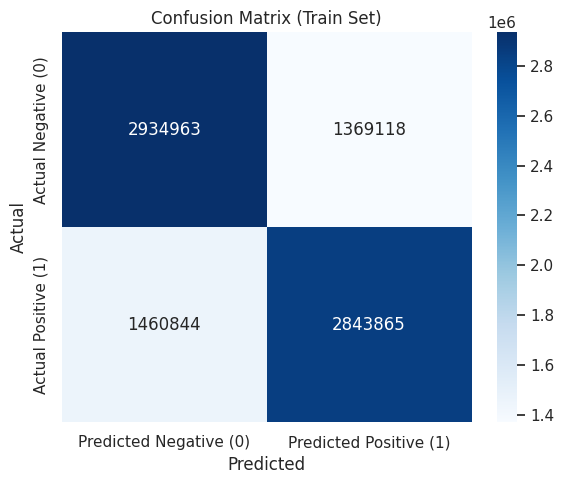

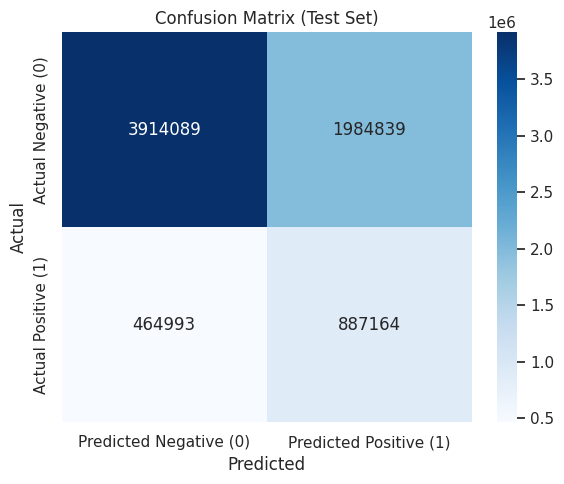

✅ Final Model Evaluation (XGBoost)
Train F2 Score (XGBoost): 0.663468
Test  F2 Score (XGBoost): 0.535686
Time to Train Model (XGBoost): 3.4 minutes
Time to Evaluate on Test Data (XGBoost): 0.0 minutes


In [0]:
import time

# Train final model on full training data using XGB
best_parameters_xgb = {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}
model_type = 'xgboost'
pipeline_xgb = get_model(model_type, tree_pipeline, best_parameters_xgb)

# Measure time for model training
start_time_train_xgb = time.time()
xgb_model = pipeline_xgb.fit(df_train_downsampled.dropna())
end_time_train_xgb = time.time()

# Evaluate on training data
train_pred_xgb = xgb_model.transform(df_train_downsampled.dropna())
eval_train_xgb = evaluate_classification_model(train_pred_xgb)

# Plot confusion matrix
plot_confusion_matrix(eval_train_xgb["Confusion Matrix Values"], title_suffix="Train Set")

# Measure time for model evaluation on test data
start_time_test_xgb = time.time()
test_pred_xgb = xgb_model.transform(df_test.dropna())
end_time_test_xgb = time.time()

# Evaluate on test data
eval_test_xgb = evaluate_classification_model(test_pred_xgb)

# Plot confusion matrix
plot_confusion_matrix(eval_test_xgb["Confusion Matrix Values"], title_suffix="Test Set")

# Calculate build times
train_build_time_xgb = (end_time_train_xgb - start_time_train_xgb) / 60
test_build_time_xgb = (end_time_test_xgb - start_time_test_xgb) / 60

# Print results
print("✅ Final Model Evaluation (XGBoost)")

# Model performance metrics
print(f"Train F2 Score (XGBoost): {eval_train_xgb['f2_score']:.6f}")
print(f"Test  F2 Score (XGBoost): {eval_test_xgb['f2_score']:.6f}")

# Model build times
print(f"Time to Train Model (XGBoost): {train_build_time_xgb:.1f} minutes")
print(f"Time to Evaluate on Test Data (XGBoost): {test_build_time_xgb:.1f} minutes")


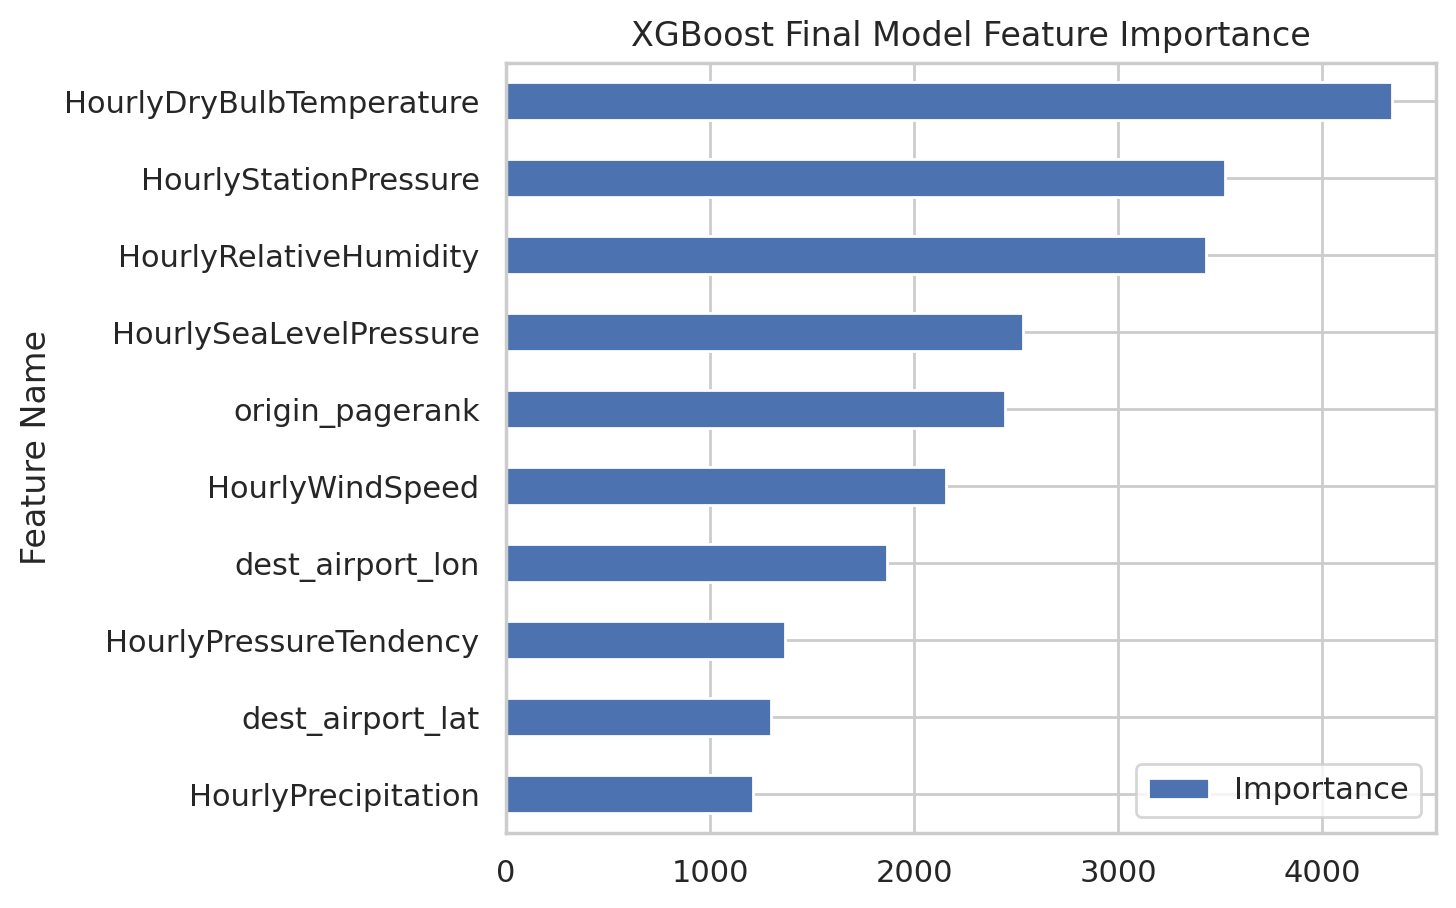

In [0]:
# Plot the feature importance on final selected model
# Get the booster object from the trained XGBoost model
booster = xgb_model.stages[-1].get_booster()  # Access the booster object from the XGBoost model

# Get raw importances (can also use 'weight', 'gain', or 'cover')
importances = booster.get_score(importance_type='weight')  

# Get actual feature names from the pipeline
feature_names = xgb_model.stages[0].getInputCols()

# Map 'f0', 'f1', etc. to feature names
feature_importance_dict = {
    feature_names[int(k[1:])]: v for k, v in importances.items() 
    if int(k[1:]) < len(feature_names)
}

# Plot the feature importance
plot_feature_importance(feature_importance_dict, "XGBoost Final Model")

# Final Gradient Boosting Tree Model Evaluation

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

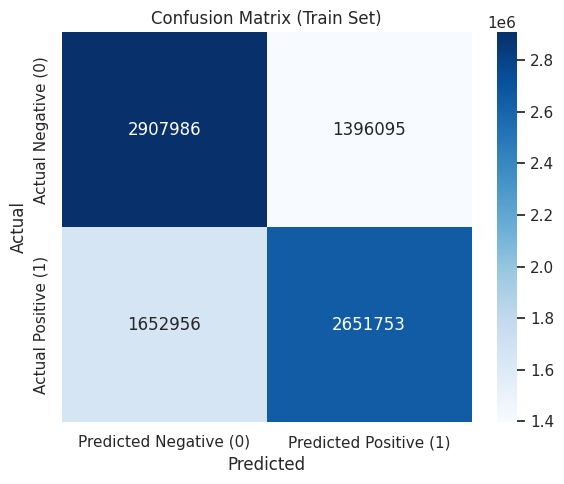

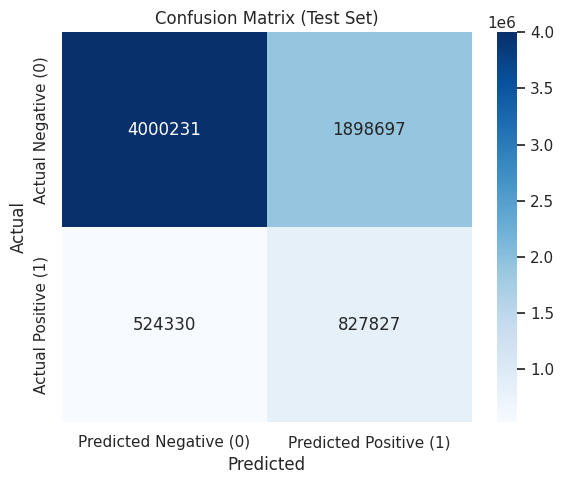

✅ Final Model Evaluation (GBT)
Train F2 Score (GBT): 0.623452
Test  F2 Score (GBT): 0.508796
Time to Train Model (GBT): 13.4 minutes
Time to Evaluate on Test Data (GBT): 0.0 minutes


In [0]:
import time

# Train final model on full training data using GBT
best_parameters_gbt = {'maxDepth': 6, 'maxBins': 32, 'maxIter': 10, 'stepSize': 0.01}
model_type = 'gbt'
pipeline_gbt = get_model(model_type, tree_pipeline, best_parameters_gbt)

# Measure time for model training
start_time_train_gbt = time.time()
gbt_model = pipeline_gbt.fit(df_train_downsampled.dropna())
end_time_train_gbt = time.time()

# Evaluate on training data
train_pred_gbt = gbt_model.transform(df_train_downsampled.dropna())
eval_train_gbt = evaluate_classification_model(train_pred_gbt)

# Plot confusion matrix
plot_confusion_matrix(eval_train_gbt["Confusion Matrix Values"], title_suffix="Train Set")

# Measure time for model evaluation on test data
start_time_test_gbt = time.time()
test_pred_gbt = gbt_model.transform(df_test.dropna())
end_time_test_gbt = time.time()

# Evaluate on test data
eval_test_gbt = evaluate_classification_model(test_pred_gbt)

# Plot confusion matrix
plot_confusion_matrix(eval_test_gbt["Confusion Matrix Values"], title_suffix="Test Set")


# Calculate build times
train_build_time_gbt = (end_time_train_gbt - start_time_train_gbt) / 60
test_build_time_gbt = (end_time_test_gbt - start_time_test_gbt) / 60

# Print results
print("✅ Final Model Evaluation (GBT)")

# Model performance metrics
print(f"Train F2 Score (GBT): {eval_train_gbt['f2_score']:.6f}")
print(f"Test  F2 Score (GBT): {eval_test_gbt['f2_score']:.6f}")

# Model build times
print(f"Time to Train Model (GBT): {train_build_time_gbt:.1f} minutes")
print(f"Time to Evaluate on Test Data (GBT): {test_build_time_gbt:.1f} minutes")

Feature names: ['dest_airport_lat', 'dest_airport_lon', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWindGustSpeed', 'HourlyWindSpeed', 'origin_pagerank', 'dest_pagerank']


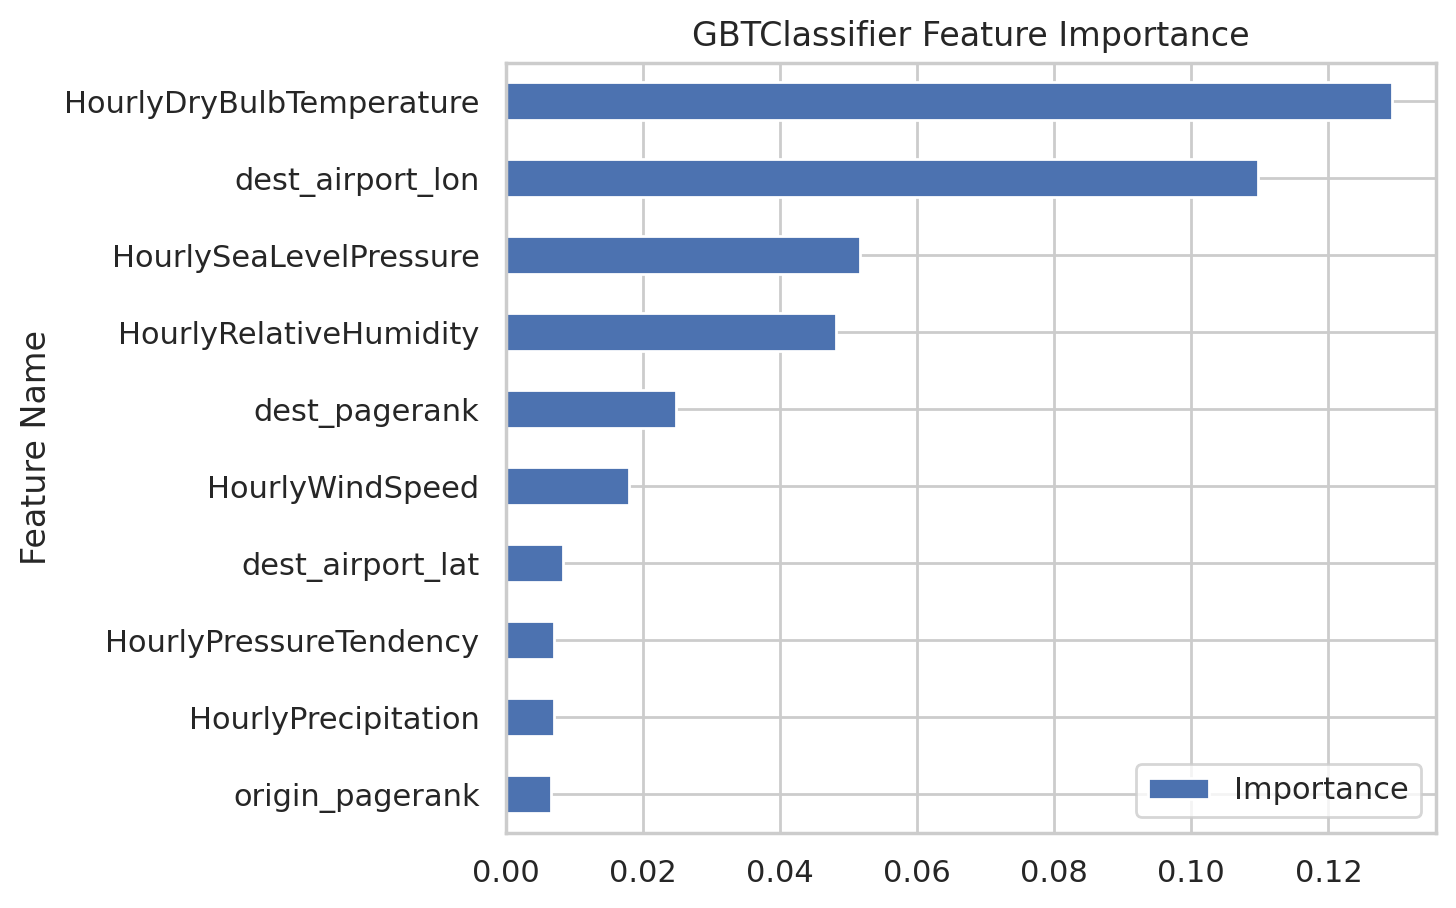

In [0]:
# Access the GBTClassifier stage
gbt = gbt_model.stages[-1]

# Access feature names from the first stage (VectorAssembler)
vector_assembler_stage = gbt_model.stages[0]

# Ensure that the stage is a VectorAssembler (or other feature engineering stage)
if hasattr(vector_assembler_stage, 'getInputCols'):
    feature_names_gbt = vector_assembler_stage.getInputCols()
    print("Feature names:", feature_names_gbt)
else:
    print("No VectorAssembler stage found. Make sure the pipeline includes feature engineering.")

# Get importance values
feature_importance_dict_gbt = dict(zip(feature_names_gbt, gbt.featureImportances))

# Plot feature importance
plot_feature_importance(feature_importance_dict_gbt, "GBTClassifier")